In [4]:
import numpy as np
import pandas as pd
from scipy.special import logit
from fairforest import d_tree
from fairforest import utils
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [5]:
warnings.simplefilter("ignore")


In [6]:
np.random.seed(4)

In [7]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [15]:
def build_dataset(total_sample,number_of_correlated_features,number_of_important_features,number_of_uncorrelated_features,mean_correlated_0,mean_correlated_1,mean_imp_0,mean_imp_1):
    mid = int(total_sample/2)
    z0_prob = 0.3
    z1_prob = 0.6
    z = np.ones(total_sample)
    x_correlated = np.zeros((total_sample,number_of_correlated_features))
    x_important = np.zeros((total_sample,number_of_important_features))
    
    var_0 = var_1 = 1
    
    y = np.zeros(total_sample)
    for i in range (mid):
        y[i] = 1
        z[i] = np.random.binomial(1, z1_prob)
        if z[i] == 1:
            for j in range (number_of_correlated_features):
                x_correlated[i][j] = np.random.normal(mean_correlated_1[j], 1)
        else:
            for j in range (number_of_correlated_features):
                x_correlated[i][j] = np.random.normal(mean_correlated_0[j], 1)
        for k in range(number_of_important_features):
            x_important[i][k] = np.random.normal(mean_imp_1[k], 1)


    for i in range (mid):
        z[mid+i] = np.random.binomial(1, z0_prob)
        if z[mid+i] == 0:
            for j in range (number_of_correlated_features):
                x_correlated[mid+i][j] =  np.random.normal(mean_correlated_0[j], 1)
        else:
            for j in range (number_of_correlated_features):
                x_correlated[mid+i][j] = np.random.normal(mean_correlated_1[j], 1)
        for k in range(number_of_important_features):
            x_important[mid+i][k] = np.random.normal(mean_imp_0[k], 1)
    #x_unimportant =  np.random.multivariate_normal(uncorr_sample_mean, uncorr_sample_cov, size=total_sample)
    x = np.concatenate((x_correlated,x_important),axis = 1)
    x = np.concatenate((x,np.reshape(z,(-1,1))),axis = 1)
    np.random.shuffle(x)

    total_features = number_of_correlated_features+number_of_important_features+1
    column = []
    for i in range(total_features):
        column.append(str(i+1))
    print(column)
    dataframe = pd.DataFrame(x, columns = column)
    return dataframe,y


In [34]:
def print_tree(model_dtree):
    n_nodes = model_dtree.node_count
    children_left = model_dtree.children_left
    children_right = model_dtree.children_right
    feature = model_dtree.feature
    threshold = model_dtree.threshold
    impurity = model_dtree.impurity
    fair_score = model_dtree.fair_score
    samples = model_dtree.number_of_data_points
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.fairness: {sample}".format(
                    space=node_depth[i] * "\t", node=i, sample =fair_score[i]
                )
            )
        else:
            print(
                "{space}node={node} is a split node: impurity, fairness and samples at this node are {impurity},{fairness},{sample}. go to node {left} if X[:, {feature}] <= {threshold} else to node {right}."
                .format(
                    space=node_depth[i] * "\t",
                    node=i,
                    impurity = impurity[i],
                    fairness = fair_score[i],
                    sample = samples[i],
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )


In [35]:
total_sample = 100
number_of_correlated_features = 1
number_of_important_features = 1
number_of_uncorrelated_features = 0
total_feature = number_of_important_features+number_of_correlated_features+1
feature = np.arange(number_of_important_features+number_of_correlated_features+1)
score_fairness = np.zeros(number_of_important_features+number_of_correlated_features+1)
score_feature = np.zeros(number_of_important_features+number_of_correlated_features+1)
mean_correlated_1 = [11]
mean_correlated_0 = [-4]
mean_imp_1 = [50]
mean_imp_0 = [100]

In [36]:
dataframe, y = build_dataset(total_sample,number_of_correlated_features,number_of_important_features,number_of_uncorrelated_features,mean_correlated_0,mean_correlated_1,mean_imp_0,mean_imp_1)

['1', '2', '3']


[Text(185.86323529411766, 211.4, 'X[0] <= 11.03\ngini = 0.5\nsamples = 100\nvalue = [50, 50]'),
 Text(105.85588235294118, 199.32, 'X[0] <= 10.396\ngini = 0.494\nsamples = 83\nvalue = [37, 46]'),
 Text(96.00882352941177, 187.24, 'X[1] <= 49.836\ngini = 0.5\nsamples = 75\nvalue = [37, 38]'),
 Text(39.38823529411765, 175.16, 'X[1] <= 48.637\ngini = 0.391\nsamples = 15\nvalue = [4, 11]'),
 Text(19.694117647058825, 163.07999999999998, 'X[0] <= -3.693\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(9.847058823529412, 151.0, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(29.541176470588237, 151.0, 'X[0] <= 3.118\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(19.694117647058825, 138.92000000000002, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(39.38823529411765, 138.92000000000002, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(59.082352941176474, 163.07999999999998, 'X[1] <= 49.34\ngini = 0.165\nsamples = 11\nvalue = [1, 10]'),
 Text(49.23529411764706, 151.0, 'gini = 0.0\nsam

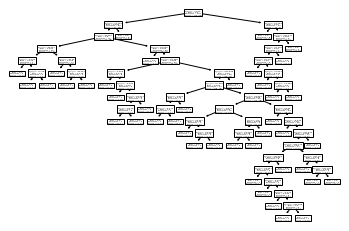

In [37]:
sklearn_tree = DecisionTreeClassifier(random_state=0)
sklearn_tree.fit(dataframe,y)
tree.plot_tree(sklearn_tree)

In [38]:

model_dtree = d_tree.DecisionTree(2,0,'3',1)
model_dtree.fit(dataframe,y)
print_tree(model_dtree)


1.0
1.0
The binary tree structure has 81 nodes and has the following tree structure:

node=0 split node: impurity, fairness and samples are 0.5,1.0,100. to node 1 if X[:, 1] <= 11.029831424762582 else node 2.
	node=1 split node: impurity, fairness and samples are 0.4941210625635071,0.8181818181818182,83. to node 3 if X[:, 1] <= 10.396466931985415 else node 4.
	node=2 split node: impurity, fairness and samples are 0.3598615916955018,0.8181818181818182,17. to node 69 if X[:, 2] <= 50.652392839791695 else node 70.
		node=3 split node: impurity, fairness and samples are 0.499911111111111,0.5555555555555556,75. to node 5 if X[:, 2] <= 49.83580356327589 else node 6.
		node=4 is a leaf node.fairness: 0.5555555555555556
			node=5 split node: impurity, fairness and samples are 0.3911111111111112,0.9857142857142858,15. to node 7 if X[:, 2] <= 48.63741858869862 else node 8.
			node=6 split node: impurity, fairness and samples are 0.4949999999999999,0.9857142857142858,60. to node 17 if X[:, 2] <= 

In [39]:

model_dtree_eqop = d_tree.DecisionTree(2,0,'3',1)
model_dtree_eqop.fit(dataframe,y)
print_tree(model_dtree_eqop)


1.0
1.0
The binary tree structure has 81 nodes and has the following tree structure:

node=0 split node: impurity, fairness and samples are 0.5,1.0,100. to node 1 if X[:, 1] <= 11.029831424762582 else node 2.
	node=1 split node: impurity, fairness and samples are 0.4941210625635071,0.8181818181818182,83. to node 3 if X[:, 1] <= 10.396466931985415 else node 4.
	node=2 split node: impurity, fairness and samples are 0.3598615916955018,0.8181818181818182,17. to node 69 if X[:, 2] <= 50.652392839791695 else node 70.
		node=3 split node: impurity, fairness and samples are 0.499911111111111,0.5555555555555556,75. to node 5 if X[:, 2] <= 49.83580356327589 else node 6.
		node=4 is a leaf node.fairness: 0.5555555555555556
			node=5 split node: impurity, fairness and samples are 0.3911111111111112,0.9857142857142858,15. to node 7 if X[:, 2] <= 48.63741858869862 else node 8.
			node=6 split node: impurity, fairness and samples are 0.4949999999999999,0.9857142857142858,60. to node 17 if X[:, 2] <= 